<a href="https://colab.research.google.com/github/agapiko/Early_Detection_Of_DIABETIC_RETINOPATHY/blob/main/InceptionNetV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import notebook
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from prettytable import PrettyTable
from sklearn.metrics import cohen_kappa_score
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 16

In [ ]:
df = pd.read_csv('/content/drive/My Drive/labels.csv')

In [ ]:
# Initial 70-30 split for train and temp (which includes validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(
    df['id_code'], df['diagnosis'], test_size=0.30, stratify=df['diagnosis'], random_state=100
)

# Further split temp into 50-50 (15% validation, 15% test)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=100
)

# Reset indices for the splits
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

base_image_path = '/content/drive/My Drive/train_images_ben_preprocessed_sigmaX10'

# Update x_train, x_val, and x_test
x_train = x_train.apply(lambda i: os.path.join(base_image_path, f'{i}.png'))
x_val = x_val.apply(lambda i: os.path.join(base_image_path, f'{i}.png'))
x_test = x_test.apply(lambda i: os.path.join(base_image_path, f'{i}.png'))

In [ ]:
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def process_image(path, img_size):
    img = cv2.imread(path)
    return cv2.resize(img, (img_size, img_size))

def load_images_parallel(image_paths, img_size, num_workers=4):
    images = np.empty((len(image_paths), img_size, img_size, 3), dtype='uint8')
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, path, img_size) for path in image_paths]
        for i, future in enumerate(tqdm(futures)):
            images[i] = future.result()
    return images

# Load train images
train_images = load_images_parallel(x_train, IMG_SIZE)

# Load validation images
val_images = load_images_parallel(x_val, IMG_SIZE)

# Load test images
test_images = load_images_parallel(x_test, IMG_SIZE)

100%|██████████| 550/550 [00:44<00:00, 12.31it/s]


In [ ]:
# Convert y_train, y_val, and y_test to one-hot encoded format
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_val).values
y_test = pd.get_dummies(y_test).values

# Normalize the images to [0, 1] by dividing by 255.0
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert boolean labels to integers (0/1)
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [ ]:
class QWKCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, num_classes):
        super(QWKCallback, self).__init__()
        self.validation_data = validation_data
        self.num_classes = num_classes
        self.qwk_scores = []  # To store QWK scores for each epoch
        self.val_qwk_scores = []  # To store validation QWK scores
        self.best_qwk = -np.inf  # Track the best QWK score

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_pred = self.model.predict(val_data)

        try:
            val_pred_labels = np.argmax(val_pred, axis=1)
            val_true_labels = np.argmax(val_labels, axis=1)

            # Calculate QWK using sklearn's cohen_kappa_score
            qwk_score = cohen_kappa_score(val_true_labels, val_pred_labels, weights='quadratic')
            print(f" - val_qwk: {qwk_score:.4f}")

            # Store QWK scores for plotting later
            self.val_qwk_scores.append(qwk_score)

            # Track QWK in logs so it appears in history
            logs['val_qwk'] = qwk_score

            # Save the best QWK score
            if qwk_score > self.best_qwk:
              self.best_qwk = qwk_score
              print(f"Validation QWK improved to {qwk_score:.4f}, saving model.")
              self.model.save(f'/content/drive/My Drive/inception_qwk_best_model_{round(self.best_qwk, 2)}.keras')

        except Exception as e:
          print(f"Error in QWK calculation: {e}")
          raise e  # Re-raise the exception to debug

In [ ]:
# Load the InceptionV3 model with ImageNet weights
incnet = InceptionV3(weights='imagenet',
                     include_top=False,
                     input_shape=(IMG_SIZE, IMG_SIZE, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers on top of InceptionV3
x = incnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
incnet_op = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_in = tf.keras.Model(inputs=incnet.inputs, outputs=incnet_op)
model_in.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 127, 127, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 127, 127, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 125, 125, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 125, 125, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 125, 125, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 125, 125, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 125, 125, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 62, 62, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 62, 62, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 62, 62, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 60, 60, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,813,029 (83.21 MB)

 Trainable params: 21,778,597 (83.08 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
model_in.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              metrics=['accuracy']
              )

qwk_callback = QWKCallback(validation_data=(val_images, y_val), num_classes=5)

# Training dataset with augmentation, shuffling, batching, and prefetching
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(train_images))
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, y_val)).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping: Stop training if `val_loss` does not improve after 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,  # Minimum improvement
    patience=3,  # Number of epochs to wait before stopping
    verbose=1,
    mode='auto'
)

# Reduce Learning Rate if `val_loss` does not improve after 2 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=0.0004,  # Minimum change to qualify as improvement
    patience=2,  # Number of epochs to wait before reducing learning rate
    factor=0.1,  # Reduce learning rate by this factor (new_lr = current_lr * factor)
    min_lr=1e-6,  # Minimum learning rate
    verbose=1,
    mode='auto'
)

In [ ]:
import time
# Start time
start_time = time.time()

# Train the model
history = model_in.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[qwk_callback, early_stop, reduce_lr]
    )

# End time
end_time = time.time()

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 443ms/step
 - val_qwk: 0.8139
Validation QWK improved to 0.8139, saving model.
161/161 ━━━━━━━━━━━━━━━━━━━━ 161s 507ms/step - accuracy: 0.6835 - loss: 0.8864 - val_accuracy: 0.7668 - val_loss: 0.7944 - val_qwk: 0.8139 - learning_rate: 2.0000e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 - val_qwk: 0.8744
Validation QWK improved to 0.8744, saving model.
161/161 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.7694 - loss: 0.6046 - val_accuracy: 0.8142 - val_loss: 0.5595 - val_qwk: 0.8744 - learning_rate: 2.0000e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 - val_qwk: 0.8756
Validation QWK improved to 0.8756, saving model.
161/161 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.8142 - loss: 0.5201 - val_accuracy: 0.8051 - val_loss: 0.5380 - val_qwk: 0.8756 - learning_rate: 2.0000e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 - val_qwk: 0.8704
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8307 - loss: 0.4

Text(0.5, 1.0, 'Training and Validation Accuracy')

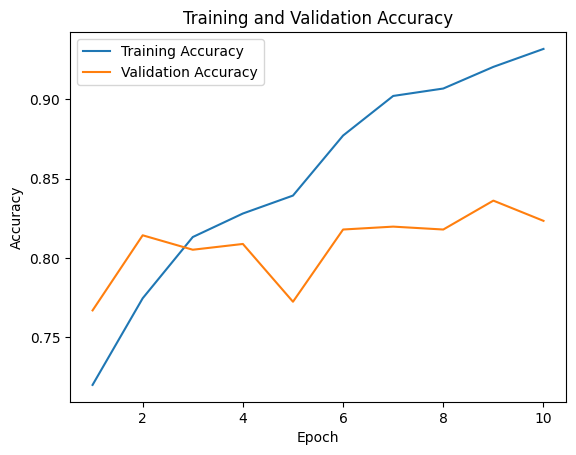

In [ ]:
n_epochs = len(history.history['loss'])  # Total number of epochs
epochs_range = range(1, n_epochs + 1)

# Plot Accuracy
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

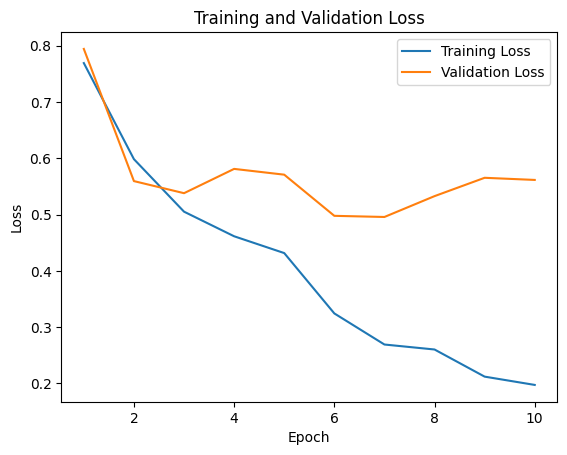

In [ ]:
# Plot Loss
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Validation QWK Score Per Epoch')

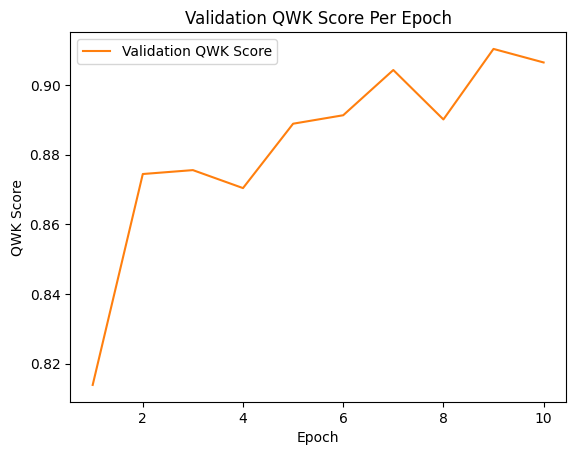

In [ ]:
# Plot QWK (Quadratic Weighted Kappa) Score
plt.plot(epochs_range, history.history['val_qwk'], label='Validation QWK Score', color='#FF7F0E')
plt.xlabel('Epoch')
plt.ylabel('QWK Score')
plt.legend()
plt.title('Validation QWK Score Per Epoch')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


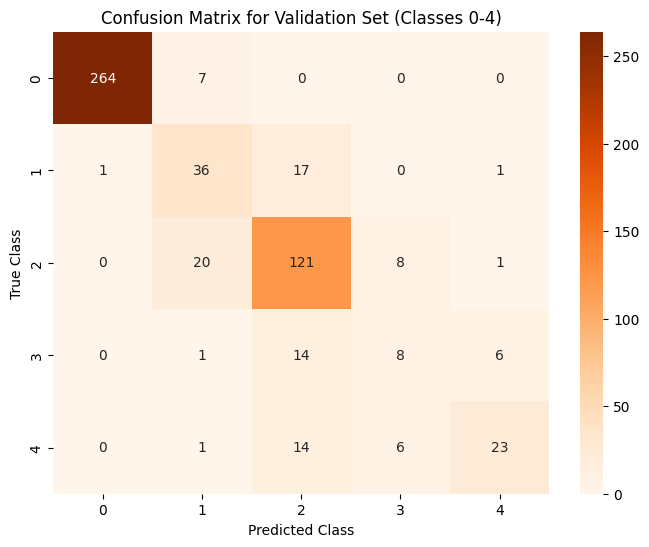

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict on validation dataset
val_predictions = model_in.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)  # Get the predicted class labels
val_true_labels = np.argmax(y_val, axis=1)  # Get the true class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1, 2, 3, 4])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix for Validation Set (Classes 0-4)')
plt.show()

## **Evaluation of InceptionNetV3 Model**

In [ ]:
# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for better performance

In [ ]:
# Predicting on the test set
test_predictions = model_in.predict(test_dataset)

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 317ms/step


In [ ]:
# Convert probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)  # Index of the highest probability

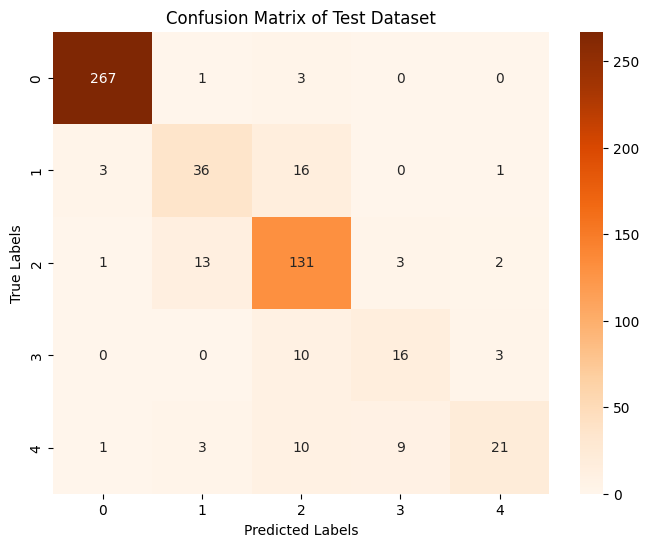

In [ ]:
from sklearn.metrics import confusion_matrix

# True labels for the test set
true_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix using Oranges color map
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Test Dataset')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix, cohen_kappa_score
import time

def evaluate_model(model, test_dataset, y_test):

    # Measure computational time for predictions
    start_time = time.time()
    test_predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(test_predictions, axis=1)
    end_time = time.time()
    computation_time = end_time - start_time

    true_labels = np.argmax(y_test, axis=1)

    # Accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # F1-Score (weighted average for multi-class)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Sensitivity (Recall) for the model (macro average)
    sensitivity = recall_score(true_labels, predicted_labels, average='macro')

    # Specificity manually
    TN = conf_matrix.sum() - (conf_matrix.sum(axis=0) - np.diag(conf_matrix)).sum()  # True Negatives
    FP = (conf_matrix.sum(axis=0) - np.diag(conf_matrix)).sum()  # False Positives
    specificity = TN / (TN + FP)  # Specificity

    # AUC Score
    auc_score = roc_auc_score(y_test, test_predictions, multi_class="ovr")

    # Cohen's Kappa Score
    kappa = cohen_kappa_score(true_labels, predicted_labels, weights='quadratic')

    results = pd.DataFrame({
        'Metric': ['Accuracy', 'F1-Score', 'Sensitivity (Recall)', 'Specificity', 'AUC Score', 'Quadratic Weighted Kappa Score'],
        'Value': [accuracy, f1, sensitivity, specificity, auc_score, kappa]
    })

    return results

# Calculate and print the time taken
training_time = end_time - start_time

model_results = evaluate_model(model_in, test_dataset, y_test)
print(model_results)
print(f"Total training time: {training_time:.2f} seconds")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                           Metric     Value
0                        Accuracy  0.856364
1                        F1-Score  0.852037
2            Sensitivity (Recall)  0.706085
3                     Specificity  0.856364
4                       AUC Score  0.947709
5  Quadratic Weighted Kappa Score  0.898909
Total training time: 295.67 seconds
